<a href="https://colab.research.google.com/github/Henry6612700/Data-Science/blob/master/productdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian --upgrade -q
import jovian
jovian.set_project('object-detection')
jovian.set_colab_id('1EgtAwvmGL-WbgvMX9O3v7WIIt4XsDAn9')

     |████████████████████████████████| 71kB 5.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline


In [ ]:
DATA_DIR = 'drive/MyDrive/input'

TRAIN_DIR = DATA_DIR + '/train/train'                           
TEST_DIR = DATA_DIR + '/test/test'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = DATA_DIR + '/test.csv'   

In [ ]:
data_df = pd.read_csv(TRAIN_CSV)
data_df

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3
...,...,...
64136,4937b7acdaef4f5e4e104ab1eb5f3dca.jpg,22
64137,e118b5a21a3f1f0d387c315f2f1a91db.jpg,22
64138,08084af6fa34f41224c58c8e78ebf766.jpg,22
64139,01c18e570209c1524fb2f575afe688b2.jpg,22


In [ ]:
print("Total number of images:",len(data_df))
print("Total categories: ",len(data_df.category.drop_duplicates()))


Total number of images: 64141
Total categories:  25


In [ ]:
class ProductImageDataset(Dataset):
    def __init__(self, df, root_dir, transform = None, test = False):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.test = test
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['filename'], row['category']
        if self.test == False:
            img_fname = self.root_dir + "/" + "{0:0=2d}".format(img_label) + "/" + str(img_id)
        else:
            img_fname = self.root_dir + "/" + str(img_id)
        img = Image.open(img_fname)
        img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_label

**Data Augmentation**

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.Resize((224,224)),
    T.RandomCrop(size=(224,224),padding=(10,10)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15,fill=0),
     T.ToTensor(), 
     T.Normalize(*imagenet_stats)
])

valid_tfms = T.Compose([
    T.Resize((224,224)), 
    T.ToTensor(), 
     T.Normalize(*imagenet_stats)
])

In [ ]:
np.random.seed(42)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_df, test_size=0.1, stratify=data_df.category)
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [ ]:
train_ds = ProductImageDataset(train_df, TRAIN_DIR, transform=train_tfms, test = False)
val_ds = ProductImageDataset(val_df, TRAIN_DIR, transform=valid_tfms,test = False)
len(train_ds), len(val_ds)

(57726, 6415)

In [ ]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: 15


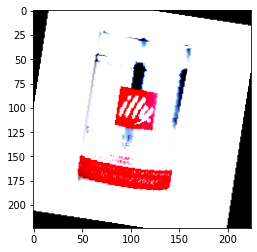

In [ ]:
show_sample(*train_ds[154])

**Data Loaders**

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=14).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


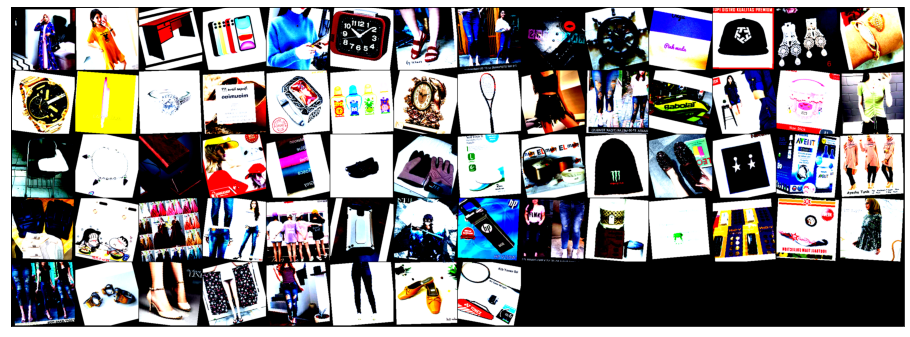

In [ ]:
show_batch(train_dl)

**Model**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ProductCnn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 112 x 112
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 56 x 56

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 28 x 28
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 14 x 14

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 7 x 7

            nn.Flatten(), 
            nn.Linear(256*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 42))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

**Training**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
   
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
           
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
           
            lrs.append(get_lr(optimizer))
            sched.step()
        
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model_basic_cnn = to_device(ProductCnn(), device)

In [ ]:
history_basic_cnn = [evaluate(model_basic_cnn, val_dl)]
history_basic_cnn

[{'val_acc': 0.02934027649462223, 'val_loss': 3.7351746559143066}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.SGD

In [ ]:
%%time
history_basic_cnn += fit_one_cycle(epochs, max_lr, model_basic_cnn, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00280, train_loss: 3.4375, val_loss: 3.1660, val_acc: 0.0772


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_accuracies(history_basic_cnn)

In [ ]:
plot_losses(history_basic_cnn)


In [ ]:
plot_lrs(history_basic_cnn)

**Prediction**

In [ ]:
def decode_target(target):
    _, preds  = torch.max(target, dim=0)
    return preds

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model_basic_cnn(xb)
    prediction = decode_target(preds[0])
    show_sample(image, prediction)

In [ ]:
class ProductImageDataset_Test(Datasets):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['filename'], row['category']
        img_fname = self.root_dir + "/" + str(img_id)
        img = Image.open(img_fname)
        img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_label
    
test_df = pd.read_csv(TEST_CSV)
test_dataset = ProductImageDataset_Test(test_df, TEST_DIR, transform=valid_tfms)

In [ ]:
predict_single(test_dataset[74][0])

In [ ]:
predict_single(test_dataset[64][0])

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model_basic_cnn) 

In [ ]:
test_preds = [p.item() for p in test_preds]
test_preds

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.category = test_preds
submission_df.sample(20)

In [ ]:
submission_df["category"] = submission_df.category.apply(lambda c: str(c).zfill(2))

In [ ]:
submission_df.sample(20)

In [ ]:
submission_df.to_csv('submission.csv', index=False)

In [ ]:
test_preds = pd.DataFrame(test_preds).to_csv('/content/drive/My Drive/test_preds.csv')

In [ ]:
torch.save(model_basic_cnn.state_dict(), 'CNN.pth')
weights_fname = 'CNN.pth'

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()



In [ ]:
project_name='productdetection1'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])